In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import colormaps
from matplotlib.colors import Normalize


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.stats import diagnostic

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from statsmodels.stats.outliers_influence import variance_inflation_factor

Wczytywanie danych

In [5]:
database = pd.read_csv('car_prices.csv')
database.shape

(558837, 16)

Ujednolicenie marek pojazdów poprzez ustawienie pierwszej litery marki na wielką oraz rozszerzenie nazw.

In [6]:
# database['make'] = database['make'].str.title()
# database['make'] = database['make'].replace({'Vw': 'Volkswagen', 'Mercedes-B':'Mercedes-Benz','Mercedes':'Mercedes-Benz'})
# print(database.head(5))
database.loc[:, 'make'] = database['make'].str.title()
database.loc[:, 'make'] = database['make'].replace({'Vw': 'Volkswagen', 'Mercedes-B':'Mercedes-Benz','Mercedes':'Mercedes-Benz','Dodge': 'Dodge Tk'})

Wyczyszczenie danych z pojazdów których ilość jest mniejsza niż 0,01%

In [7]:
# database['make'] = database['make'].str.title()
# models_count_by_make = database.groupby('make')['make'].transform('count')
# database[models_count_by_make >=len(database)*0.0001]
# database.shape

Usunięcie wierszy zawierających wartości N/A w kolumnie 'mmr' oraz 'sellingprice'

In [8]:
# # database.dropna(subset=['mmr','sellingprice'],axis='rows')
database = database.dropna(subset=['make','mmr','sellingprice'],axis='rows')
database.shape

(548498, 16)

In [9]:
print(database.head(5))

   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    Bmw             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    Bmw  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motors ameri

Wykres ilości sprzedanych pojazdów wg. marek

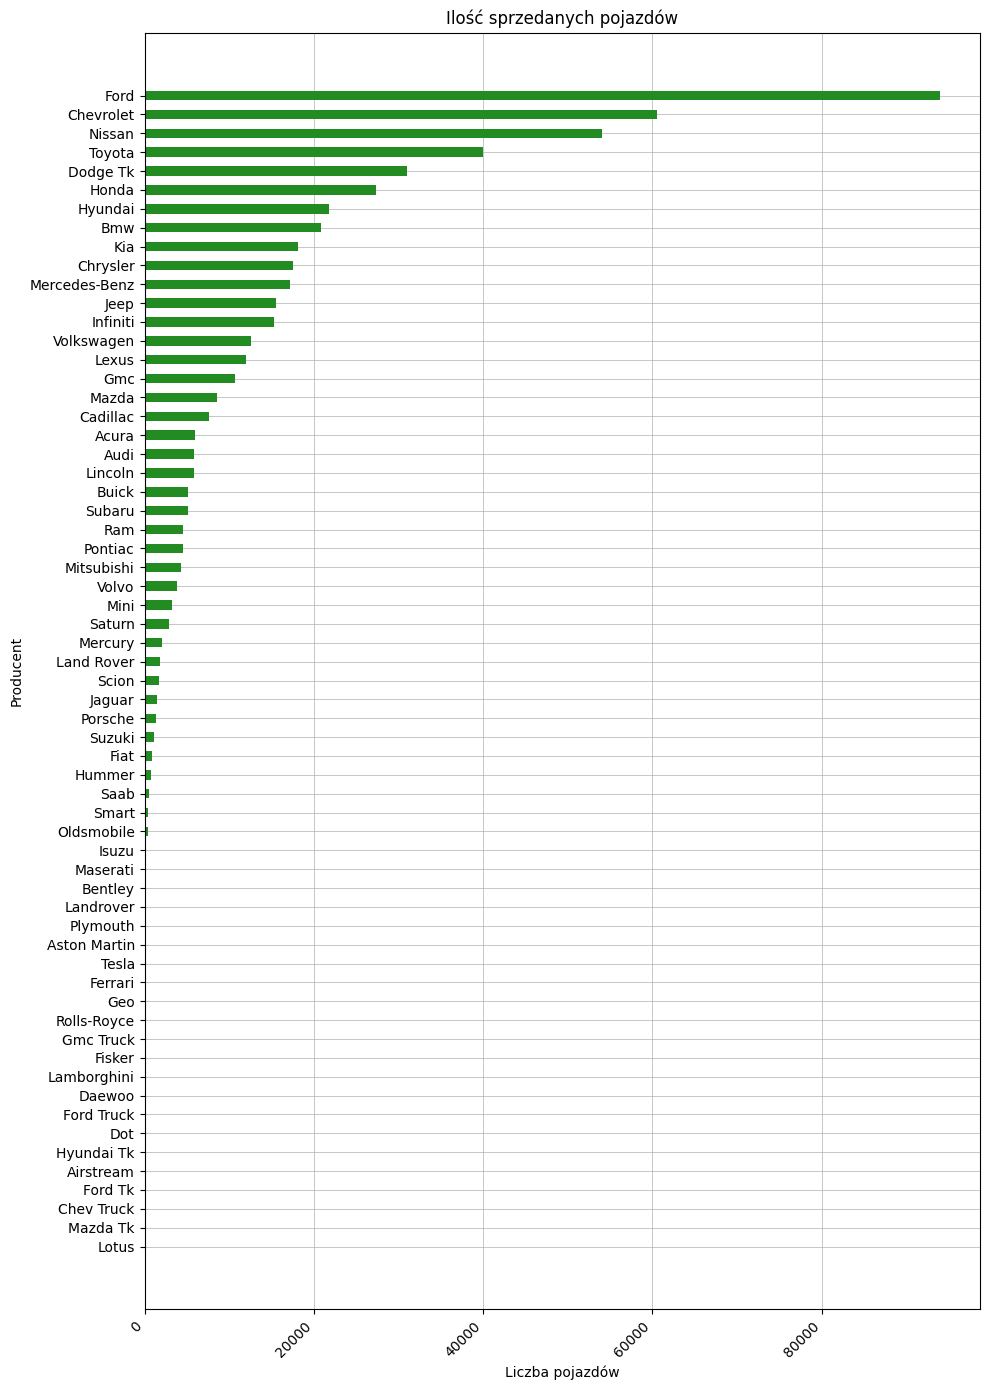

In [10]:
model_car_sum = database['make'].value_counts()
model_car_filtered = model_car_sum[model_car_sum>0]

plt.figure(figsize=(10, 14))
plt.barh(model_car_filtered.index, model_car_filtered.values, height=0.5,color='forestgreen', zorder=2)
plt.xlabel('Liczba pojazdów')
plt.ylabel('Producent')
plt.title('Ilość sprzedanych pojazdów')
plt.xticks(rotation=45, ha='right')
plt.gca().invert_yaxis()
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.tight_layout()
plt.show()

Rozkład ilości pojazdów w zależności od roku produkcji

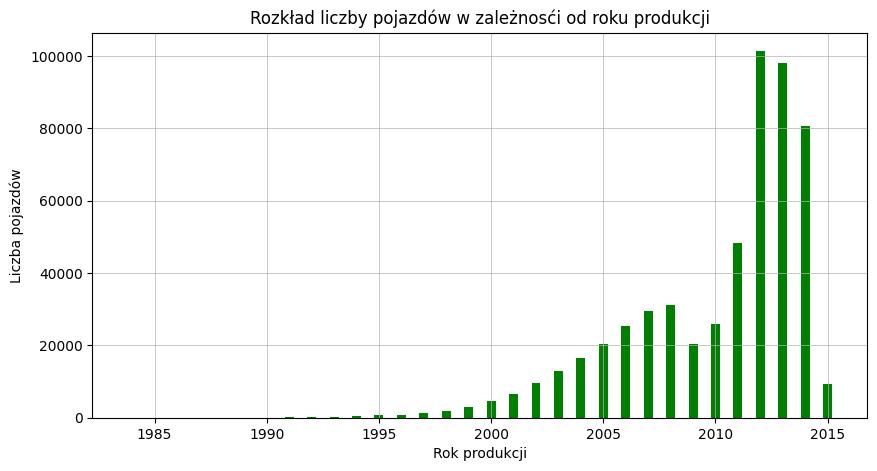

In [11]:
df_age = database['year'].value_counts()

fig = plt.figure(figsize = (10, 5))
 
years = df_age.index
counts = df_age.values

plt.bar(years, counts, color='green', width=0.4)

plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
 
plt.xlabel("Rok produkcji")
plt.ylabel("Liczba pojazdów")
plt.title("Rozkład liczby pojazdów w zależnosći od roku produkcji")
plt.show()

Średni przebieg pojazdów wg marki

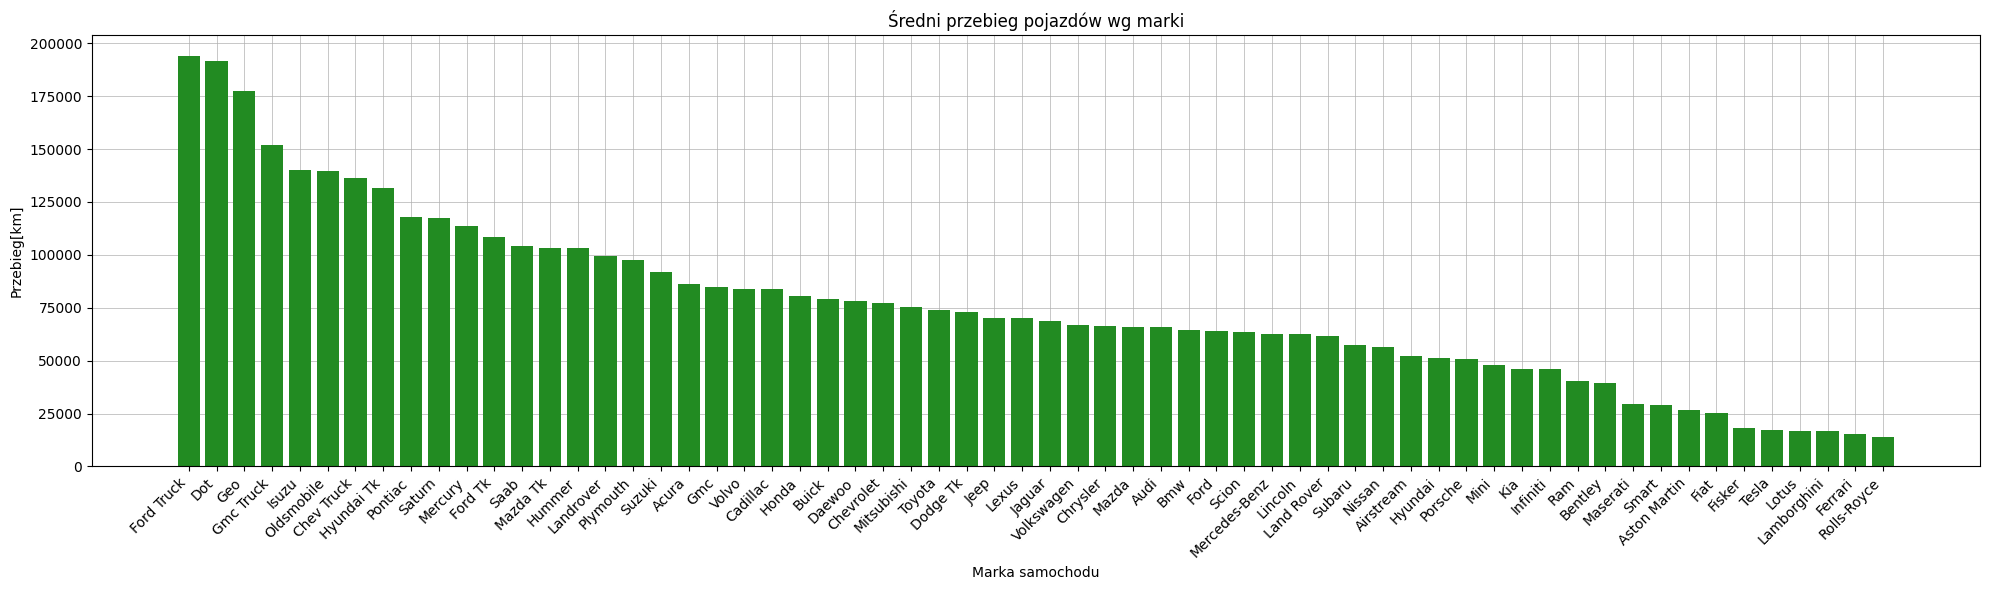

In [12]:
mean_odometer = database.groupby('make')['odometer'].mean()
mean_odometer_sorted = mean_odometer.sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.bar(mean_odometer_sorted.index, mean_odometer_sorted.values, color='forestgreen', zorder=2)
plt.xlabel('Marka samochodu')
plt.ylabel('Przebieg[km]')
plt.title('Średni przebieg pojazdów wg marki')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


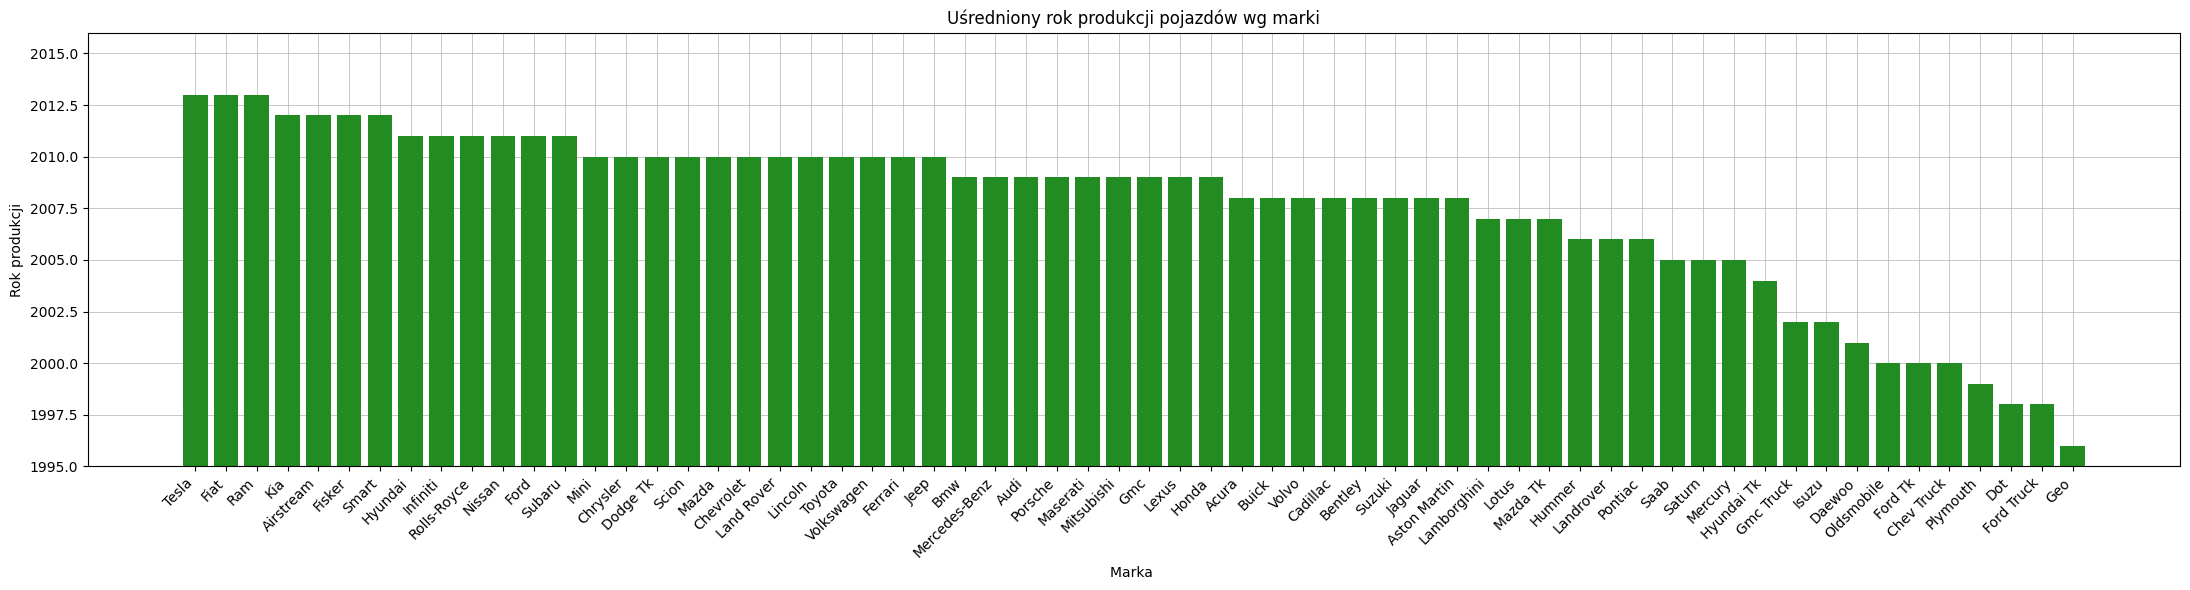

In [13]:

mean_age = database.groupby('make')['year'].mean()
mean_age_sorted = mean_age.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_age_sorted.index, mean_age_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka ')
plt.ylabel('Rok produkcji')
plt.title('Uśredniony rok produkcji pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.ylim(1995, 2016)
plt.tight_layout()
plt.show()

Średnia cena pojazdu wg marki

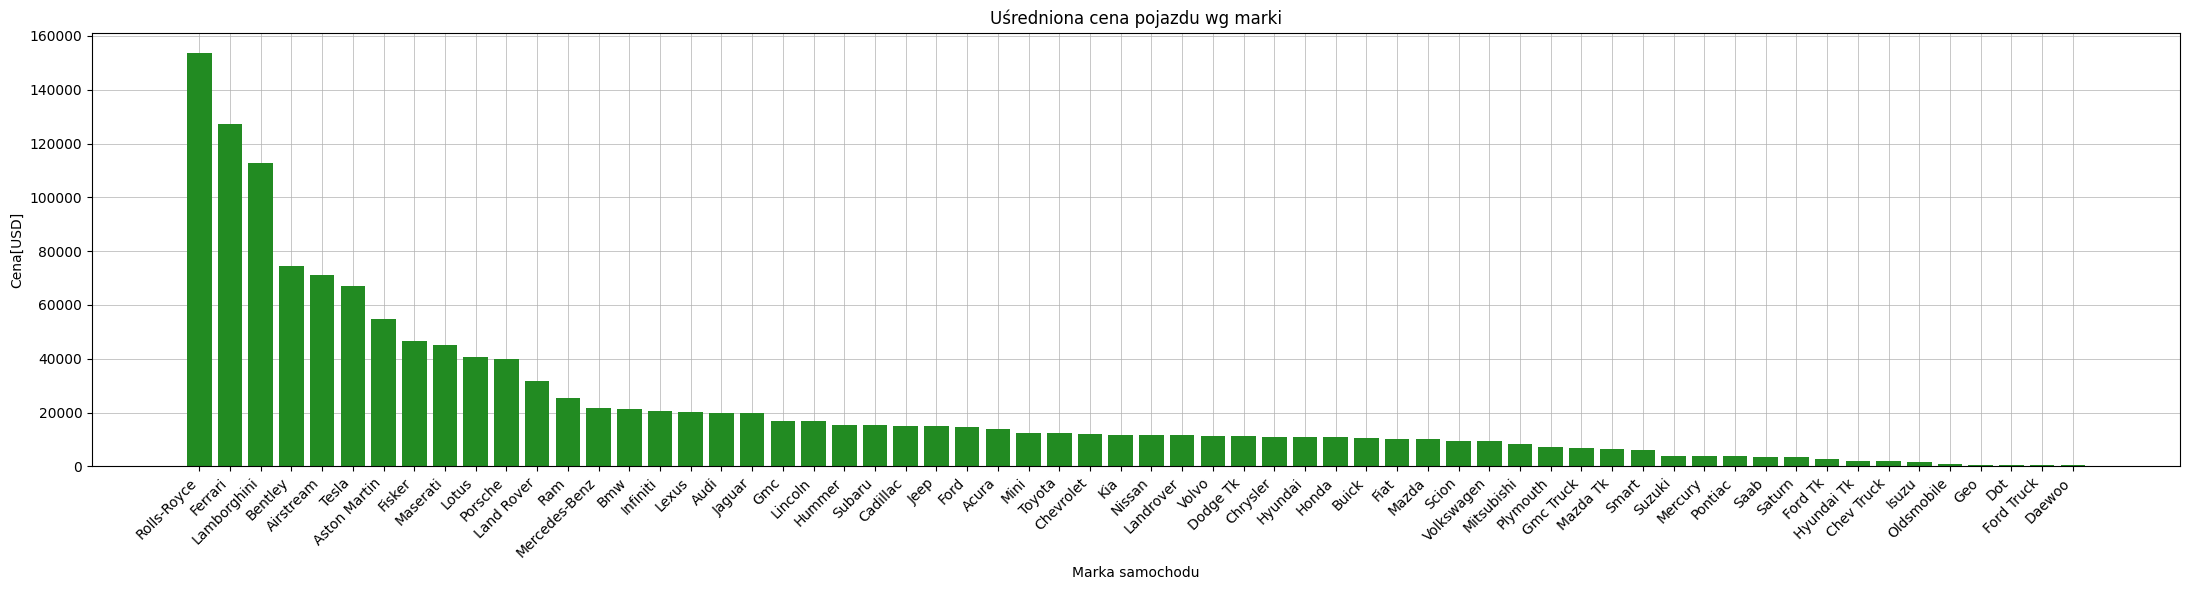

In [14]:
mean_price = database.groupby('make')['sellingprice'].mean()
mean_price_sorted = mean_price.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_price_sorted.index, mean_price_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka samochodu')
plt.ylabel('Cena[USD]')
plt.title('Uśredniona cena pojazdu wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

10 najdroższych marek wraz z 5 modelami

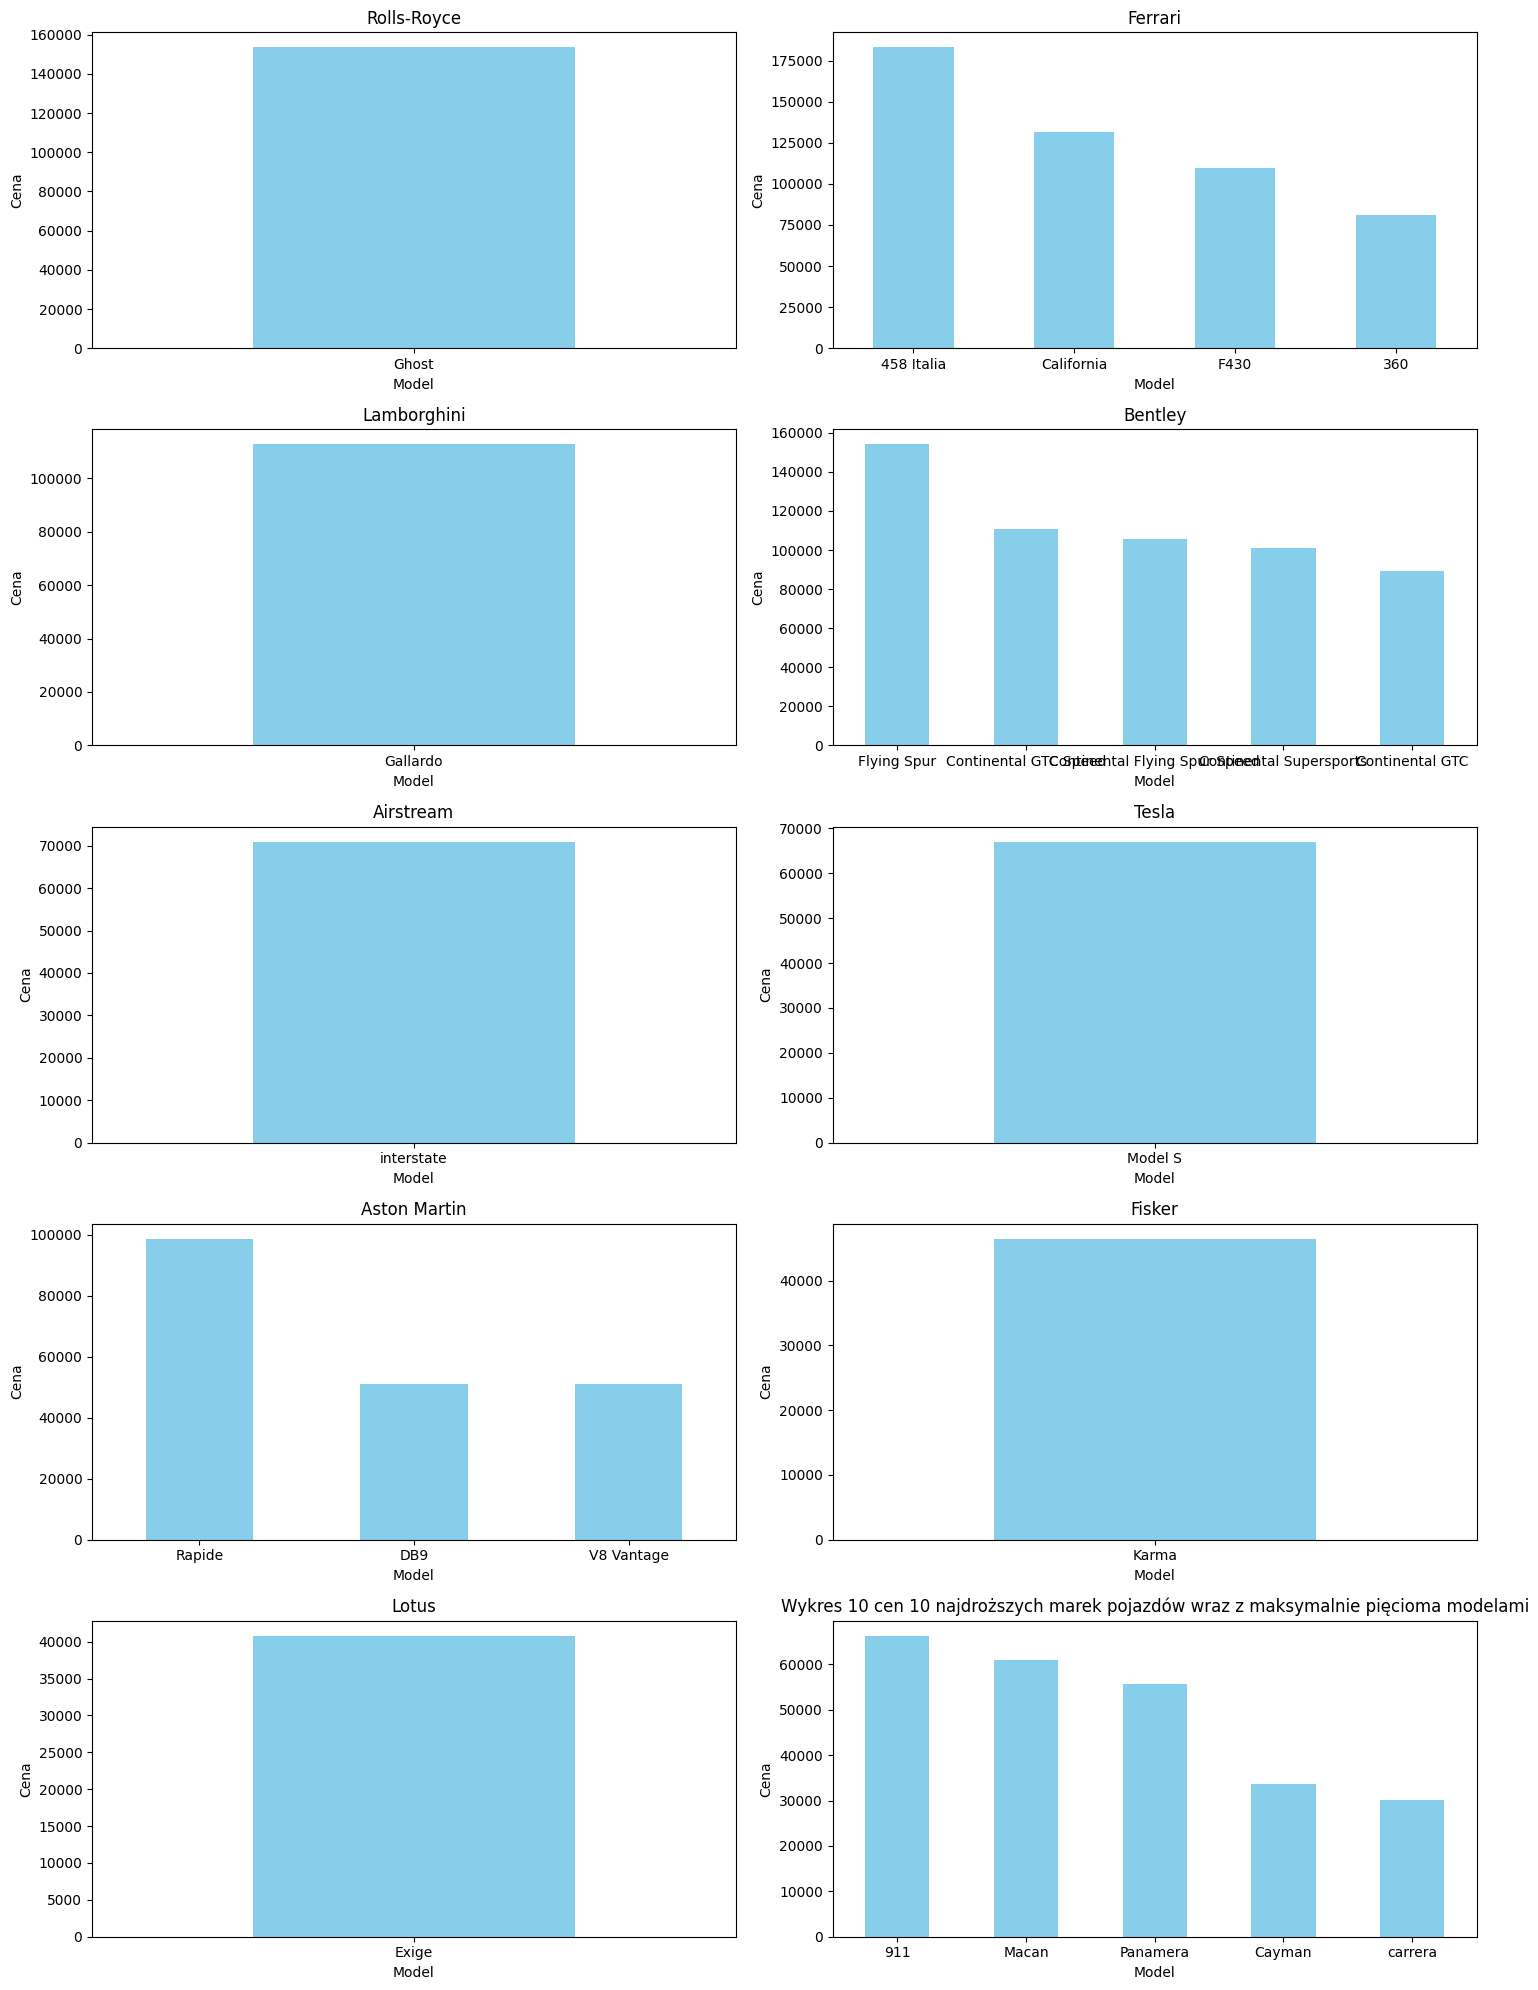

In [15]:
average_prices = database.groupby(['make', 'model'])['sellingprice'].mean()

top_makes = average_prices.groupby('make').mean().nlargest(10)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 2 * len(top_makes)))

for i, (make, avg_price) in enumerate(top_makes.items()):
    top_models = average_prices.loc[make].nlargest(5)
    
    top_models.plot(kind='bar', ax=axes[i // 2, i % 2], color='skyblue')
    
    axes[i // 2, i % 2].set_title(make)
    axes[i // 2, i % 2].set_ylabel('Cena')
    axes[i // 2, i % 2].set_xlabel('Model')
    axes[i // 2, i % 2].tick_params(axis='x', rotation=0)

plt.title('Wykres 10 cen 10 najdroższych marek pojazdów wraz z maksymalnie pięcioma modelami')
plt.tight_layout()
plt.show()

Regresja liniowa

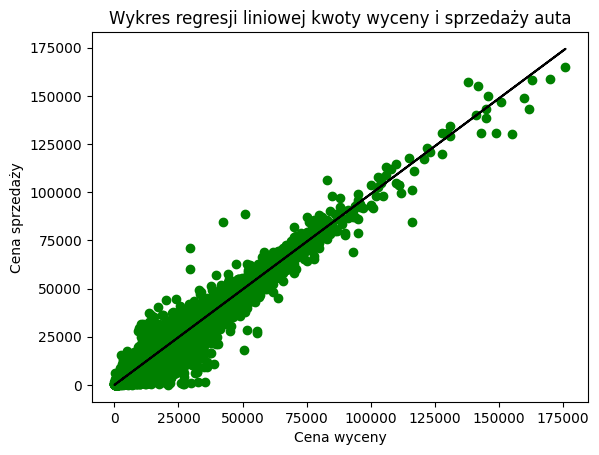

In [16]:
from sklearn.linear_model import LinearRegression

data = database.dropna(axis='rows', subset=['mmr', 'sellingprice', 'make'])

X = data['mmr'].values.reshape(-1,1)
y = data['sellingprice']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 1410)

reg = LinearRegression().fit(X_train, y_train)
res = reg.score(X_test, y_test)

y_pred = reg.predict(X_test)
plt.scatter(X_test, y_test, color ='green')
plt.plot(X_test, y_pred, color ='k')
plt.title('Wykres regresji liniowej kwoty wyceny i sprzedaży auta')

plt.xlabel('Cena wyceny')
plt.ylabel('Cena sprzedaży')
 
plt.show()



Korelacja danych

In [23]:
import pandas as pd

data_corr = pd.DataFrame(database)

#1 only numeric data
numeric_data = data_corr.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
#2 one-hot encoding

# data_encoded = pd.get_dummies(data)

# correlation_matrix = data_encoded.corr()
print(correlation_matrix)
# print(data_corr.corr())

                  year  condition  odometer       mmr  sellingprice
year          1.000000   0.335159 -0.775065  0.595582      0.585413
condition     0.335159   1.000000 -0.314491  0.276482      0.317336
odometer     -0.775065  -0.314491  1.000000 -0.586140     -0.580432
mmr           0.595582   0.276482 -0.586140  1.000000      0.983599
sellingprice  0.585413   0.317336 -0.580432  0.983599      1.000000


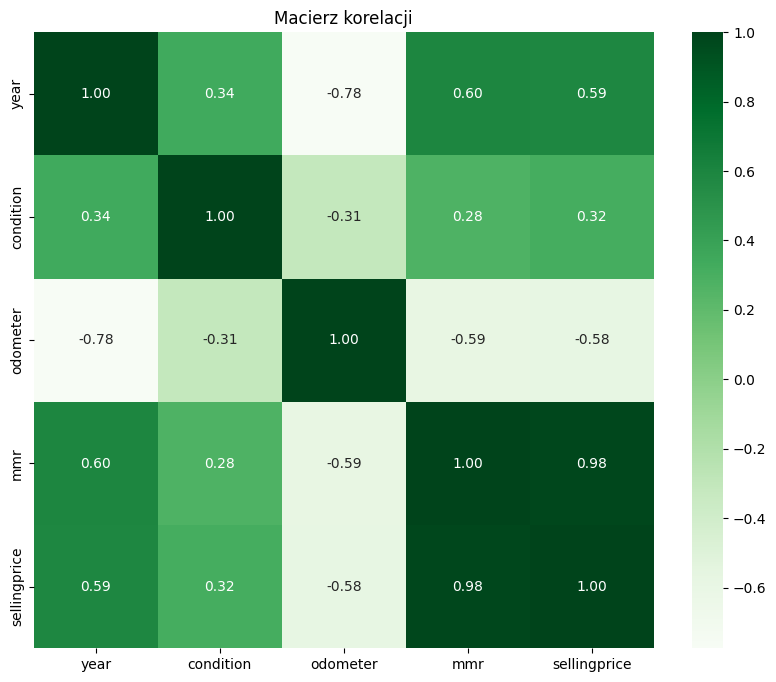

In [28]:
import seaborn as sns

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")

plt.title('Macierz korelacji')

plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

data_Tree_price = data.copy()

X = data_Tree_price['make']
y = data_Tree_price['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

X_2d = X.values.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(X_2d)

c:\Users\micha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Cena sprzedaży za pomocą Drzew decyzyjnych

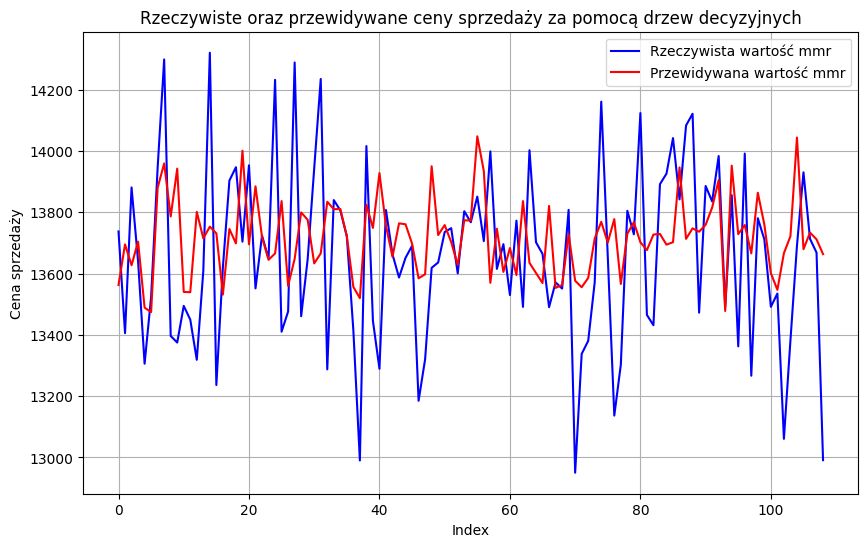

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=1410)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
tree_metric = mean_absolute_percentage_error(y_test, y_pred)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')
plt.xlabel('Index')
plt.ylabel('Cena sprzedaży')
plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

data_Tree = data

X = pd.get_dummies(data_Tree['make'])
y = data_Tree['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
tree_metric = mean_absolute_percentage_error(y_test, y_pred)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
print('Jakość predykcji:', tree_metric)



Jakość predykcji: 1.2876707258533855


MMR - To narzędzie, które śledzi ceny samochodów na rynku wtórnym. To przydatne narzędzie dla dealerów samochodowych, kupujących i sprzedających, ponieważ dostarcza aktualnych informacji na temat wartości rynkowej różnych modeli samochodów. MMR zbiera dane z transakcji na aukcjach samochodowych oraz innych źródeł, aby określić przeciętne ceny pojazdów i trendów cenowych.

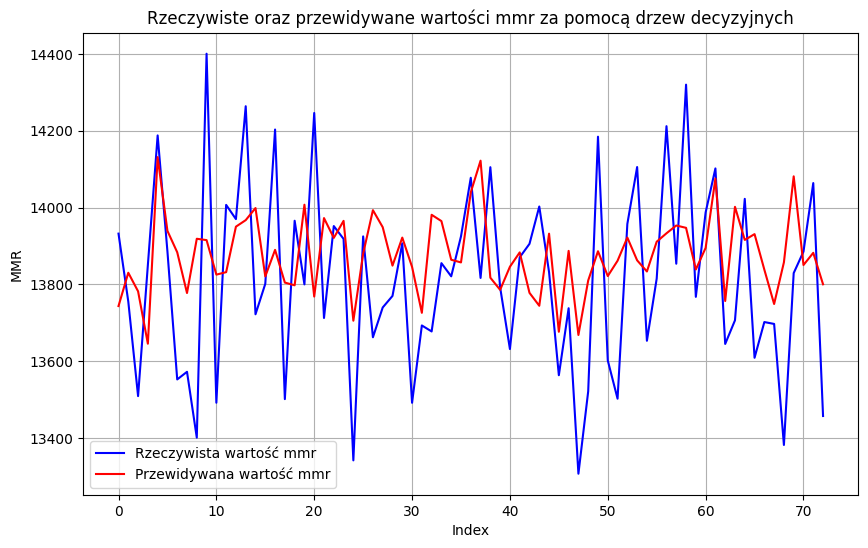

In [ ]:
bins = np.arange(0, len(y_test) + 1, 1500)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('MMR')
plt.title('Rzeczywiste oraz przewidywane wartości mmr za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
data_MLP = data

X = pd.get_dummies(data_MLP['make'])
y = data_MLP['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

mlp_model = MLPRegressor(hidden_layer_sizes=10)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

c:\Users\micha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print(mean_absolute_percentage_error(y_test, y_pred))

1.290738216205641


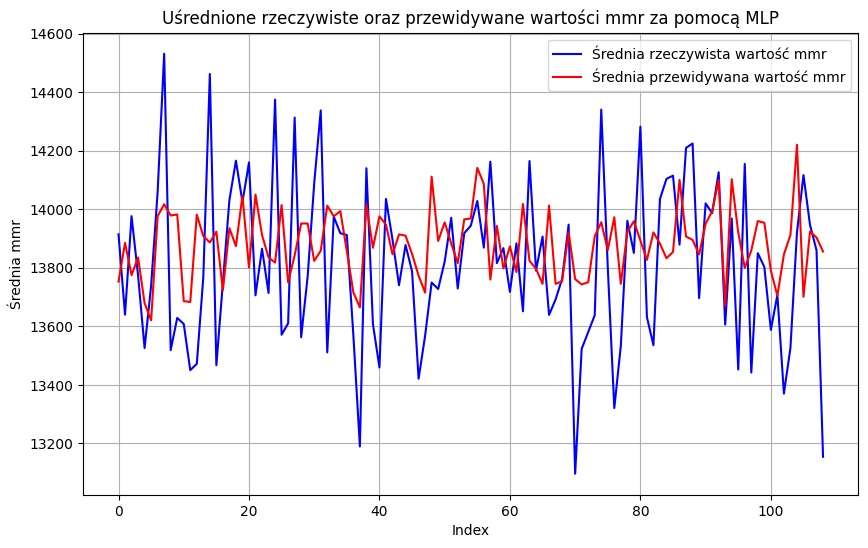

In [ ]:
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą MLP')
plt.legend()
plt.grid()

plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

data_KNN = data

X = pd.get_dummies(data_KNN['make'])
y = data_KNN['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

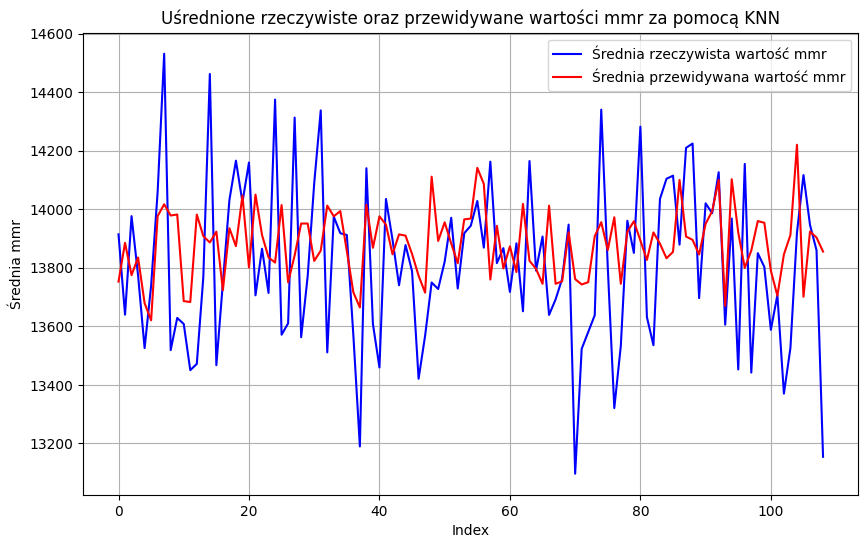

In [ ]:
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą KNN')
plt.legend()
plt.grid()

plt.show()